# Assignment 9: Exercise 3


In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

mu      = 0
gamma   = 1
n_init  = 1000000
sigma_a = 0.3 
#Remark: Compared to the question sheet, 
#here I set the volatility at a lower value 
#in order to obtain nicer ("smoother") graphs. 
#With 45% annualized volatility, the liquidation speed 
#was very high, as you have seen in your simulations!

time_start = '09:00:00'
time_end   = '16:00:00'

def f_time_schedule(time_start,time_end,freq_sec): 
    time_schedule  = pd.date_range(time_start,time_end,freq="%sS"%freq_sec)
    return time_schedule

def f_tcosts(time_schedule,lunch_start,lunch_end,lda_low,lda_high): 
    T          = len(time_schedule)
    time_start = pd.to_datetime(lunch_start)
    time_end   = pd.to_datetime(lunch_end)
    lda        = np.empty((T,1))
    for t in range(T): 
        lda[t] = lda_low + \
            (time_schedule[t]>=time_start)*(time_schedule[t]<=time_end)*(lda_high-lda_low)
    return lda

def f_trading_pattern(mu,gamma,n_init,sigma_a,time_schedule,lunch_start,lunch_end,lda_low,lda_high):
    
    #Trade schedule volatility, & t-costs
    T              = len(time_schedule)
    sigma          = sigma_a/np.sqrt(252*(T-1))
    lda            = f_tcosts(time_schedule,lunch_start,lunch_end,lda_low,lda_high)

    #Coefficients at time t=T+1,T-1,...,1
    Q    = np.ones((T+1,1))
    q    = np.ones((T+1,1))
    C    = np.ones((T+1,1))
    Q[T] = 0
    q[T] = 0
    C[T] = 0
    for t in range(T-1,0,-1): 
        Q[t] = lda[t]*(1-lda[t]/(Q[t+1]+gamma*sigma**2+lda[t]))
        q[t] = lda[t]*(q[t+1]+mu)/(Q[t+1]+gamma*sigma**2+lda[t])
        C[t] = C[t+1]+0.5*(q[t+1]+mu)**2/(Q[t+1]+gamma*sigma**2+lda[t])

    #Optimal trading at time t=0,1,2,...T    
    tau      = np.divide(Q[:-1],lda)
    aim      = np.divide(q[:-1],Q[:-1])
    n_o      = np.empty((T,1))
    tcost    = np.empty((T,1))
    n_o[0]   = n_init
    tcost[0] = 0
    for t in range(1,T,1): 
        n_o[t]   = tau[t]*aim[t]+(1-tau[t])*n_o[t-1]
        tcost[t] = tcost[t-1]+0.5*lda[t]*(n_o[t]-n_o[t-1])**2
    return n_o,tcost,aim,tau,Q,q,C



(d)

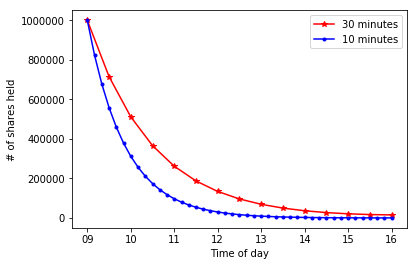

In [6]:
#30min intervals
time_schedule30 = f_time_schedule(time_start,time_end,30*60)
n30,tcost30,aim30,tau30,Q30,q30,C30 = \
    f_trading_pattern(mu,gamma,n_init,sigma_a,time_schedule30,'12:00:00','14:00:00',0.0001,0.0001)

#10min intervals
time_schedule10 = f_time_schedule(time_start,time_end,10*60)
n10,tcost10,aim10,tau10,Q10,q10,C10 = \
    f_trading_pattern(mu,gamma,n_init,sigma_a,time_schedule10,'12:00:00','14:00:00',0.0001,0.0001)

#figure
fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1 = ax1.plot(time_schedule30,n30,'r*-',label="30 minutes")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
#ax2 = ax1.twiny()
ln2 = ax1.plot(time_schedule10,n10,'b.-',label="10 minutes")
#ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
plt.xlabel('Time of day')
plt.ylabel('# of shares held')
plt.legend(loc='upper right')
plt.show() 


(f)

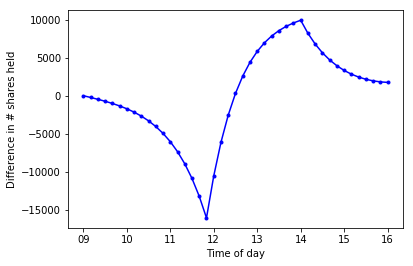

In [7]:
#with lunch break
time_schedulelun = f_time_schedule(time_start,time_end,10*60)
nlun,tcostlun,aimlun,taulun,Qlun,qlun,Clun = \
    f_trading_pattern(mu,gamma,n_init,sigma_a,time_schedulelun,'12:00:00','14:00:00',0.0001,0.001)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1 = ax1.plot(time_schedulelun,nlun-n10,'b.-')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
plt.xlabel('Time of day')
plt.ylabel('Difference in # shares held')
plt.legend(loc='upper right')
plt.show() 
